# Named Entity Recognition
The chatbot should also be able, based on the intent, to label entities that it stores in it's dialog management so that it's replies are more accurate. This notebook is where for every Tweet, I try to extract the entities. This should be added to my pipeline later.

More particularly, from the utterance as input, I want the output to be all the entities in that utterance stored in a dictionary.

In [2]:
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Deep Learning 
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow import keras
print(f"Keras: {keras.__version__}")
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# NER
import spacy
print(f'spaCy: {spacy.__version__}')
from spacy import displacy
import random
from spacy.matcher import PhraseMatcher
import plac
from pathlib import Path

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

import collections
import yaml
import pickle

# Reading back in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)

# Reading in representative intents
# with open(r'objects/intents_repr.yml') as file:
#     intents_repr = yaml.load(file, Loader=yaml.FullLoader)

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

from IPython.core.display import display, HTML
    
# Reading in training data
train = pd.read_pickle('objects/train.pkl')

print(train.head())
print(f'\nintents:\n{intents}')

# Reading in processed data
processed = pd.read_pickle('objects/processed.pkl')

Pandas: 1.0.5
Numpy: 1.18.5
Tensorflow: 2.2.0
Keras: 2.3.0-tf
Sklearn: 0.23.1
spaCy: 2.3.0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




                                           Utterance           Intent
0  [phone, battery, die, fast, within, hour, usag...          battery
1                                 [forgot, my, pass]  forgot_password
2                            [payment, not, through]          payment
3                                     [want, update]           update
4                                [need, information]             info

intents:
{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'repair': ['repair', 'fix', 'broken'], 'update': ['update']}


# Entities to Label:

<img src="visualizations/entity_list.png" alt="Drawing" style="width: 500px;"/>

In actuality, I think a string search with Regex would suffice because there isn't a lot of entities I am looking for. CRF is just a more robust way of doing NER, and would work on corpuses that are too large to really be enumerating all the rules.

# NER Methods

Named Entities are just real world objects that are assigned a name. This is often seen as a sequential prediction problem.

# Making A Customer Apple Related NER
   
I will be making my own custom entities. CRF or Rasa's DIET Classifier is good for this. Almost every chatbot will have some custom entities.

## Conditional Random Field


If I were to use CRFs for training, this is the formula I would apply:

<img src="visualizations/CRF.png" alt="Drawing" style="width: 400px;"/>

* Here, y is predefined labels
* X is the set of input vectors
* CRFs use contextual information to add to the model
* Z(X) is normalization
* Lambda are the weights

## SpaCy
However, instead of CRF, which is what the RASA bot uses, I use spaCy's NER training because it is better for pretraining and it also has good capability to custom train your data.
    
    (docs) spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.
    
To be honest, the documentation isn't the best and it's quite confusing. But I figured it out.

### <font color='red'>My approach and procedure:</font> 
In order to do a custom training (I have my own entities I want to train - namely hardware and application), here was **my procedure**:

1. Enumerated all the entities that I want to identify, then I thought of all the keywords that should be in that entity (I stored this in a `entities` dictionary)
2. Used spaCy's PhraseMatcher to identify where my keywords are in a document - PhraseMatcher is a new addition in spaCy 2.0 that allows you to efficiently do matching with a list of documents
3. Made an offset function that converted the string indexes PhraseMatcher returned into character indexes, because this is how spaCy's recognition trainer accepts the data
4. Further prepared the data to make it a tuple that spaCy recognizer accepts
5. Took just the Tweets from my processed data that contained an entity keyword and trained it with stochastic gradient descent using `nlp.update` and spaCy's NER pipe
6. Repeated for all the entities I want to custom train, otherwise for the location entity I could just use 

### Sources:
* [Training my own custom NER model](https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718)
* [NER Using CRF](https://medium.com/data-science-in-your-pocket/named-entity-recognition-ner-using-conditional-random-fields-in-nlp-3660df22e95c)
* [CRF NER with Python AI Time Journal](https://www.aitimejournal.com/@akshay.chavan/complete-tutorial-on-named-entity-recognition-ner-using-python-and-keras)
    * [His Git Repo](https://github.com/Akshayc1/named-entity-recognition)
* [Rasa Entity Extraction Docs](https://rasa.com/docs/rasa/nlu/entity-extraction/)
* [Apple Tagging](https://heartbeat.fritz.ai/natural-language-in-ios-12-customizing-tag-schemes-and-named-entity-recognition-caf2da388a9f) - This guy did what I want to do, but it's super verbose
* [Tagging schemes or types](https://natural-language-understanding.fandom.com/wiki/Named_entity_recognition)
* I got most of the code and understanding of it from [this video](https://www.youtube.com/watch?v=UxzyD6gVlC8&t=1056s)

### Schemes:
* **BIO scheme** (Beginning, Inside, Outside)
* **BILOU scheme** is more rigorous, but requires more training examples.

B is the first token of a multitoken entity, I is the token other than the first one in a multitoken entity, and O represents non-entity tokens.

### Future methods that might improve accuracy:
* Linear Chain Conditional Random Fields (Linear Chain CRF)
* Maximum Entropy Markov Models
* Bidirectional-LSTM

In [3]:
# Looks like I have to make my own training data

entities = {'hardware': ['macbook pro', 'iphone', 'iphones', 'mac',
        'ipad', 'watch', 'TV', 'airpods'],
    'apps':['app store', 'garageband', 'books', 'calendar',
           'podcasts', 'notes', 'icloud', 'music', 'messages',
           'facetime','catalina','maverick']}

# Storing it to YAML file
with open('objects/entities.yml', 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

In [4]:
entities

{'hardware': ['macbook pro',
  'iphone',
  'iphones',
  'mac',
  'ipad',
  'watch',
  'TV',
  'airpods'],
 'apps': ['app store',
  'garageband',
  'books',
  'calendar',
  'podcasts',
  'notes',
  'icloud',
  'music',
  'messages',
  'facetime',
  'catalina',
  'maverick']}

# Training Data Synthesis

Note that for my training data generation here, I do not need to use my training data I generated for my utterance (which is ~10k in length), I could use my whole Apple inbound data that is ~100k in length - and the more training examples the better my NER will be able to recognize my custom entities.

This is a sample of how my training data should look like to be able to be fed into spaCy for SGD. So the offsetter and PhraseMatcher is all done in the name of making it easier to make it into this format.

```TRAIN_DATA = [('what is the price of polo?', {'entities': [(21, 25, 'PrdName')]}), 
              ('what is the price of ball?', {'entities': [(21, 25, 'PrdName')]}), 
              ('what is the price of jegging?', {'entities': [(21, 28, 'PrdName')]}), 
              ('what is the price of t-shirt?', {'entities': [(21, 28, 'PrdName')]})]```

In [65]:
# Utility function - converts the output of the PhraseMatcher to something usable in training

def offsetter(lbl, doc, matchitem):
    ''' Converts word position to string position, because output of PhraseMatcher returns '''
    one = len(str(doc[0:matchitem[1]]))
    subdoc = doc[matchitem[1]:matchitem[2]]
    two = one + len(str(subdoc))
    
    # This function was misaligned by a factor of one character, not sure why, but
    # this is my solution
    if one != 0:
        one += 1
        two += 1
    return (one, two, lbl)

# Example
offsetter('HARDWARE', nlp('hmm macbooks are great'),(2271554079456360229, 1, 2))

(4, 12, 'HARDWARE')

Very convenient! Now we have the string index as opposed to the word index that is automatically outputted from PhraseMatcher. My manual fix also ended up working, so that's good.

In [66]:
# Load spaCy
nlp = spacy.load('en')

# Making sure ner pipe is inside
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.create_pipe('ner')

def spacify_row(document, label, entity_keywords):
    ''' Transforming a row to get it from a format of my current training data a
    format that spaCy can understand. It's quite combersome that spaCy only accepts data in this very particular format,
    but that is alright.
    '''
    # Phrase matcher - we use this class from spaCy to locate the text we want to label!
    matcher = PhraseMatcher(nlp.vocab)

    # Getting all the hardwares, and the context of how they were used in the Twitter data
    for i in entity_keywords:
        matcher.add(label, None, nlp(i))

    # Getting the matches
    nlp_document = nlp(document)
    matches = matcher(nlp_document)
    
    # Print this if  you want to get a better understanding of this function
#     print([match for match in matches])

    # As you can see, match returns me: [(2271554079456360229, 0, 1)]
    # One match is where one of the tokens in the document matches one of my entity keywords
    # (representiiation of label we passed in, word position in document 1, word position 2)
    entity_list = [offsetter(label, nlp_document, match) for match in matches]
    
    # This is what one row has to look like, so this is what I return:
    # ('what is the price of pool?', {'entities': [(21, 25, 'PrdName')]})
    return (document, {'entities': entity_list})

### Hardware Entity

In [143]:
# Defining my training data
string_utterance = processed['Processed Inbound'].progress_apply(" ".join)

# Trying for one row
spacify_row('I love my macbook and my iphone', 'HARDWARE', 
            entity_keywords = entities.get('hardware'))

('I love my macbook and my iphone', {'entities': [(25, 31, 'HARDWARE')]})

Great, here we see that the NER recognized `macbooks` and `iphone`, and gave their relative word positions. Now let's apply this to our entire training data.

In [144]:
# Getting training data by 'spacifying' my processed Twitter data and storing it in an object
entity_train = string_utterance.progress_apply(spacify_row,
                label = 'HARDWARE',              
                entity_keywords = entities.get('hardware'))

In [152]:
# Filtering out if the Tweet does not contain any of the entities
hardware_train = [(i,j) for i,j in entity_train if j['entities'] != []]

# We will be using hardware train to train the recognizer
print(f'{len(hardware_train)} out of {len(entity_train)} Tweets contain a hardware entity')

# Saving hardware train because this did take a long time to run
pickle_out = open('objects/hardware_train.pkl', 'wb')
pickle.dump(hardware_train, pickle_out)

21317 out of 76066 Tweets contain a hardware entity


### Application Entity

In [155]:
# Doing the same for my applications
entity_train = string_utterance.progress_apply(spacify_row,
                label = 'APP',              
                entity_keywords = entities.get('apps'))

# Filtering out if the Tweet does not contain any of the entities
app_train = [(i,j) for i,j in entity_train if j['entities'] != []]

# Saving
pickle_out = open('objects/app_train.pkl', 'wb')
pickle.dump(app_train, pickle_out)

# We will be using hardware train to train the recognizer
print(f'{len(app_train)} out of {len(entity_train)} Tweets contain an app entity')


5064 out of 76066 Tweets contain an app entity


In [157]:
# Preview 
hardware_train[:5]

[('iphone yes io checked update none available swipe close app several time restart',
  {'entities': [(0, 6, 'HARDWARE')]}),
 ('phone app work thank update iphone ipod',
  {'entities': [(28, 34, 'HARDWARE')]}),
 ('word even mean thing iphone owner update late software drop call history glitch apps randomly opening ihelp',
  {'entities': [(21, 27, 'HARDWARE')]}),
 ('watchos make watch pointless browsing music phone via watch reason buying it useless',
  {'entities': [(13, 18, 'HARDWARE'), (54, 59, 'HARDWARE')]}),
 ('question iphone dy quick charge time day iphone battery faulty could',
  {'entities': [(9, 15, 'HARDWARE'), (41, 47, 'HARDWARE')]})]

In [158]:
# Preview
app_train[:5]

[('show music store phone like want store music phone',
  {'entities': [(5, 10, 'APP'), (39, 44, 'APP')]}),
 ('watchos make watch pointless browsing music phone via watch reason buying it useless',
  {'entities': [(38, 43, 'APP')]}),
 ('update io iphone icloud backup greyed can not turn say last backup never',
  {'entities': [(17, 23, 'APP')]}),
 ('bug calendar app fix upgraded io still crash io',
  {'entities': [(4, 12, 'APP')]}),
 ('do apple music apple podcast regardless save phone stream',
  {'entities': [(9, 14, 'APP')]})]

Nice, this is the correct format. For the character level position indexes, the right is inclusive, and the left is a space/exclusive.

# Training the Recognizer with SGD

In [159]:
# Now we train the recognizer. 
def train_spacy(train_data, iterations):
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       
    # Add labels
    for _, annotations in train_data:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # Disable all pipes other than 'ner' during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        
        train_loss = []
        
        # Go through the training data N times
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            
            # Shuffle training data
            random.shuffle(train_data)
            
            # Iteration level metrics
            losses = {}
            misalligned_count = 0
            
            # Iterating through every Tweet
            for text, annotations in train_data:    
                try:
                    nlp.update(
                        [text],  # batch of texts
                        [annotations],  # batch of annotations
                        drop=0.2,  # dropout - make it harder to memorise data
                        sgd=optimizer,  # callable to update weights
                        losses=losses)
                except ValueError as e:
                    misalligned_count += 1
                    # If it goes here, that means there's a misaligned entity
                    print(f'Ignoring misaligned entity...\n{(text,annotations)}')
                    pass
                
            # Enable this is you want to track misalliged counts
#             print(f'-- misalligned_count (iteration {itn}): {misalligned_count}')
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (iteration {itn}): {losses}')
            
        # Visualizing the loss
        plt.figure(figsize=(10,6))
        plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
        plt.title('Loss at every iteration')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.show()
            
    return nlp

# Error rate is going up for the minimum for the path we are currently walking in
# We choose 20 for iterations, but there's a point where if you do it too many times it forgets the
# stuff it knows now

In [160]:
[*range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Misalligned means that `macbook` and `macbook pro` are both identified, as an example, and they overlap or fight for the same position.

### Training

For the number of iterations, we chose 20 because that's what the docs started with, but there's a point where if you iterate too many times it forgets the stuff it knows how already (catostrophic forgetting).

Starting iteration 0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:479: UserWarning: [W030] Some entities could not be aligned in the text "new io update last night send receive picture non-..." with entities "[(51, 57, 'HARDWARE')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:479: UserWarning: [W030] Some entities could not be aligned in the text "revert back previous software update halve battery..." with entities "[(76, 82, 'HARDWARE')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


losses (iteration 0): {'ner': 758.1979658997207}
Starting iteration 1
losses (iteration 1): {'ner': 211.96585679511315}
Starting iteration 2
losses (iteration 2): {'ner': 191.97950700832703}
Starting iteration 3
losses (iteration 3): {'ner': 153.60519273102227}
Starting iteration 4
losses (iteration 4): {'ner': 88.12393701745607}
Starting iteration 5
losses (iteration 5): {'ner': 285.1556466353411}
Starting iteration 6
losses (iteration 6): {'ner': 158.018756016454}
Starting iteration 7
losses (iteration 7): {'ner': 83.15829945751088}
Starting iteration 8
losses (iteration 8): {'ner': 107.42280087977672}
Starting iteration 9
losses (iteration 9): {'ner': 106.62408788777174}
Starting iteration 10
losses (iteration 10): {'ner': 103.7771166960625}
Starting iteration 11
losses (iteration 11): {'ner': 154.5807937604324}
Starting iteration 12
losses (iteration 12): {'ner': 97.13634470743803}
Starting iteration 13
losses (iteration 13): {'ner': 80.0807884384481}
Starting iteration 14
losses (

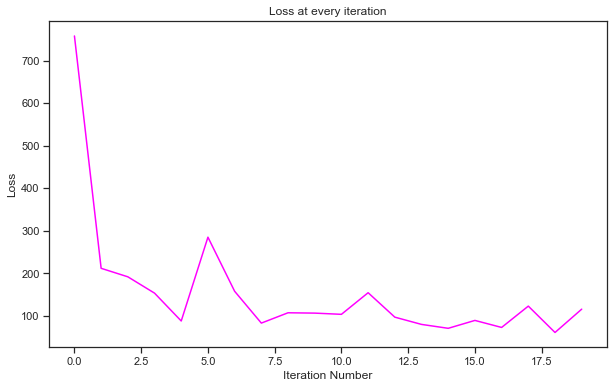

In [162]:
# Training
hardware_nlp = train_spacy(hardware_train, 20)

# Save our trained model into a new directory
hardware_nlp.to_disk('models/hardware_big_nlp')

Training seems to do fine. Error rate is going up for the minimum for the path we are currently walking in.

/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:636: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs


Starting iteration 0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:479: UserWarning: [W030] Some entities could not be aligned in the text "run loud crackle sound call new iphone non-facetim..." with entities "[(44, 52, 'APP')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:479: UserWarning: [W030] Some entities could not be aligned in the text "io make twitter crash first time ever several time..." with entities "[(58, 66, 'APP')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/spacy/language.py:479: UserWarning: [W030] Some entities could not be aligned in the text "hey pro

losses (iteration 0): {'ner': 446.1876558719226}
Starting iteration 1
losses (iteration 1): {'ner': 128.109400359902}
Starting iteration 2
losses (iteration 2): {'ner': 119.81837904375446}
Starting iteration 3
losses (iteration 3): {'ner': 40.34303022688904}
Starting iteration 4
losses (iteration 4): {'ner': 49.22037858741371}
Starting iteration 5
losses (iteration 5): {'ner': 38.65983998306026}
Starting iteration 6
losses (iteration 6): {'ner': 39.57677762776498}
Starting iteration 7
losses (iteration 7): {'ner': 44.575783240722295}
Starting iteration 8
losses (iteration 8): {'ner': 8.767531736519553}
Starting iteration 9
losses (iteration 9): {'ner': 23.395426829231727}


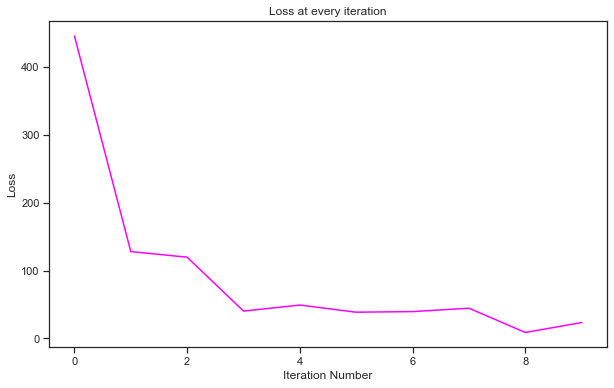

In [166]:
# Training
app_nlp = train_spacy(app_train, 10)

# Save our trained model into a new directory
app_nlp.to_disk('models/app_big_nlp')

In [188]:
# Serializing
pickle.dump(hardware_nlp, open('models/hardware_big_nlp.pkl', "wb"))
pickle.dump(app_nlp, open('models/app_big_nlp.pkl', "wb"))

# Evaluation and Results

In [198]:
# Testing out the results
test_text = 'My iphone sucks but my macbook pro doesnt. Why couldnt they make\
            my iphone better. At least I could use airpods with it. Mcabook pro is\
            the best! Apple watches too. Maybe if they made the iphone more like the\
            ipad or my TV it would be alright. Mac. Ugh.'

def extract_hardware(user_input, visualize = False):
    # Loading it in
    hardware_nlp = pickle.load(open("models/hardware_big_nlp.pkl", "rb"))
    doc = hardware_nlp(user_input)

    extracted_entities = []

    # These are the objects you can take out
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))

    # If you want to visualize
    if visualize == True:
        # Visualizing with displaCy how the document had it's entity tagged (runs a server)
        colors = {"HARDWARE": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
        options = {"ents": ["HARDWARE"], "colors": colors}
        html = displacy.render(doc, style = 'ent', options = options)
        display(HTML(html));
        # displacy.serve(doc, style="ent", options=options)
        # displacy.serve(doc, style="ent")
    return extracted_entities

def extract_app(user_input, visualize = False):
    # Loading it in
    app_nlp = pickle.load(open("models/app_big_nlp.pkl", "rb"))
    doc = app_nlp(user_input)

    extracted_entities = []

    # These are the objects you can take out
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))

    # If you want to visualize
    if visualize == True:
        # Visualizing with displaCy how the document had it's entity tagged (runs a server)
        colors = {"APP": "#F8C471"}
        options = {"ents": ["APP"], "colors": colors}
        html = displacy.render(doc, style = 'ent', options = options)
        display(HTML(html));
        # displacy.serve(doc, style="ent", options=options)
        # displacy.serve(doc, style="ent")
    return extracted_entities

In [193]:
extract_hardware(test_text, visualize = True)

<IPython.core.display.HTML object>

[('iphone', 3, 9, 'HARDWARE'),
 ('macbook pro', 23, 34, 'HARDWARE'),
 ('iphone', 79, 85, 'HARDWARE'),
 ('airpods', 115, 122, 'HARDWARE'),
 ('Mcabook pro', 132, 143, 'HARDWARE'),
 ('iphone', 210, 216, 'HARDWARE'),
 ('ipad', 242, 246, 'HARDWARE'),
 ('Mac', 277, 280, 'HARDWARE')]

In [199]:
test_text = "My top favorite apps include the facetime application, the apple books on my iphone, and the podcasts\
        application. Sometimes instead of spotify I would listen to apple music. My macbook is running\
        Catalina btw."

extract_app(test_text, visualize = True)

<IPython.core.display.HTML object>

[('facetime', 33, 41, 'APP'),
 ('podcasts', 93, 101, 'APP'),
 ('music', 175, 180, 'APP')]

As demoed above, the model actually does quite a good job labelling the entities! The only false positive is Why, but that could be dealt with.

In [100]:
# Viewing the pipeline's contents
hardware_nlp.pipeline

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x196101fe50>)]

### Motivation for training my own custom NER

In [197]:
# Example of spaCy's default NER pipeline

nlp = spacy.load("en_core_web_sm")

# Example 1
doc = nlp("But Google is starting from behind. The company \
          made a late push\ninto hardware, and Apple’s Siri, \
          available on iPhones, and Amazon’s Alexa\nsoftware, \
          which runs on its Echo and Dot devices, have clear \
          leads in\nconsumer adoption")

# Example 2 - Extracting locations
doc = nlp("I live in California")

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

# Visualizing with displaCy how the document had it's entity tagged
# html = displacy.serve(doc, style="ent")
html = displacy.render(doc, style = 'ent')
display(HTML(html))

<IPython.core.display.HTML object>

We see that right off the box, spaCy's tool does not recognize iphones, apple phones, as the correct entity. They only understood Apple is an Organization. Therefore, I trained my custom model that was able to understand Apple specific keywords.